(hybridsvm)=

# Квантово-классический SVM

Автор(ы):

- [Синченко Семен](https://github.com/SemyonSinchenko)


## Описание лекции

Лекция будет построена следующим образом:

- посмотрим, как можно использовать **VQC** как ядро SVM;
- напишем и применим код обучения смешанного SVM.

Перед тем как приступить, рекомендуется освежить [материал](../../qsvm/ru/classic_svm.md) по классическому методу опорных векторов, в частности, нужно понимать, как работает ядерный трюк.

## VQC как ядерная функция

Как мы много говорили в более ранних лекциях, квантовые схемы позволяют нам оперировать в гильбертовых пространствах волновых функций. Эти пространства имеют экспоненциально большую размерность, при этом они параметризуются линейным количеством параметров. А еще в этих пространствах определены скалярные произведения волновых функций, более того, именно результат выборки из скалярного произведения мы чаще всего и получаем как результат измерений!

Давайте попробуем посмотреть, что общего у **VQC** и ядер.

- оба оперируют в пространстве большой (или бесконечной размерности);
- и там, и там работа идет в гильбертовом пространстве и определено скалярное произведение;
- и там, и там результат вычисляется как скалярное произведение.

```{note}
Это интересно, что многие специалисты в области **QML** сегодня даже предлагают вместо термина "квантовая нейросеть" использовать термин "квантовое ядро", так как математически **VQC** гораздо ближе именно к ядрам, чем к слоям современных глубоких сетей.
```

Очевидная идея -- попробовать как-то воспользоваться квантовой схемой, чтобы реализовать скалярное произведение двух классических векторов. Именно это и сделали авторы работы {cite}`qsvmidea`.

### Преобразование состояния

На самом деле, если просто использовать какие-то простые квантовые операции, мы не получим какого-то преимущества над классическим ядерным SVM -- ведь все то же самое можно будет сделать и на классическом компьютере.

Чтобы получить реальное преимущество, нам необходимо использовать запутывание и прочие "фишки" квантовых вычислений.

Дальше мы не станем изобретать велосипеды, а вместо этого воспользуемся примерами хороших преобразований из работы {cite}`qsvmmap`. Рассмотрим, что именно там описано.

#### Общая схема

Для простоты формул мы не будем выписывать обобщенные формулы, а все будем писать для нашего двумерного пространства. Тогда наша схема может быть разделена на несколько частей:

- гейты Адамара и гейты $CNOT$;
- операции, основанные на элементах входного вектора;
- попарные операции над парами элементов вектора.

Мы начинаем с того, что переводим кубиты в состояние суперпозиции, применяя операторы Адамара. Далее мы применяем однокубитные параметризованные операции и снова гейты Адамара. После этого мы применяем связку $CNOT \to$ параметризованная парой операция $\to CNOT$.

#### Выбор операции

Следуя идее упомянутой статьи, в качестве что одно-элементной, что двух-элементной операции мы будем использовать гейт $U_1$. Разница будет лишь в том, что мы передаем на вход в качестве параметра.

#### Feature function

В качестве параметров на входе гейта $U_1$, как мы уже говорили, выступают один или два элемента вектора $x$. Строго это можно записать как функцию такого вида:

$$
\phi(x_1, x_2) = \begin{cases}
\phi(x),\text{    }x_1 = x_2 \\
\phi(x_1, x_2),\text{    }x_1 \neq x_2
\end{cases}
$$

Мы будем называть ее _feature function_. В некотором смысле можно сказать, что именно эта функция определяет тип ядра по аналогии с классическим SVM. В работе {cite}`qsvmmap` описано много разных вариантов таких _feature function_, мы будем использовать следующую:

$$
\begin{gathered}
\phi(x) = x \\
\phi(x_1, x_2) = \pi \cos{x_1} \cos{x_2}
\end{gathered}
$$

#### Скалярное произведение

Все что мы описали выше, обозначим как квантовую схему $U(x)$. Она преобразует нам вектор классических данных $x$ в квантовое состояние $\ket{\Psi}$. Но нам то нужно получить скалярное произведение $\braket{U(x_1)|U(x_2)}$! Выглядит сложно, но на самом деле существует эффективный способ получить эту величину без необходимости восстанавливать весь вектор состояния. Можно показать, что величина $\braket{U(x_1)|U(x_2)}$ равна вероятности нулевой битовой строки ($\ket{0, 0, ...., 0}$) при измерении другой схемы: $U(x_1)U(x_2)^\dagger$.

Все это может казаться сложным и запутанным, но должно стать гораздо понятнее, когда мы посмотрим на пример реализации от начала и до конца.

## Пример реализации

### Схема

Для начала необходимые импорты.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import make_moons

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

Помимо всех привычных, нам еще потребуется классический SVM из `scikit-learn`:

In [2]:
from sklearn.svm import SVC

Мы будем работать с уже привычным нам набором "Tow Moons". Только в этом случае мы будем использовать чуть-чуть другую нормализацию -- для нашего ядра элементы вектора $x$ должны быть в интервале $[-1, 1]$. Сразу переведем наши данные в этот диапазон:

In [3]:
def normalize(x):
    """Переводит значения в интервал от -1 до 1"""

    return 2 * (x - x.min()) / (x.max() - x.min()) - 1

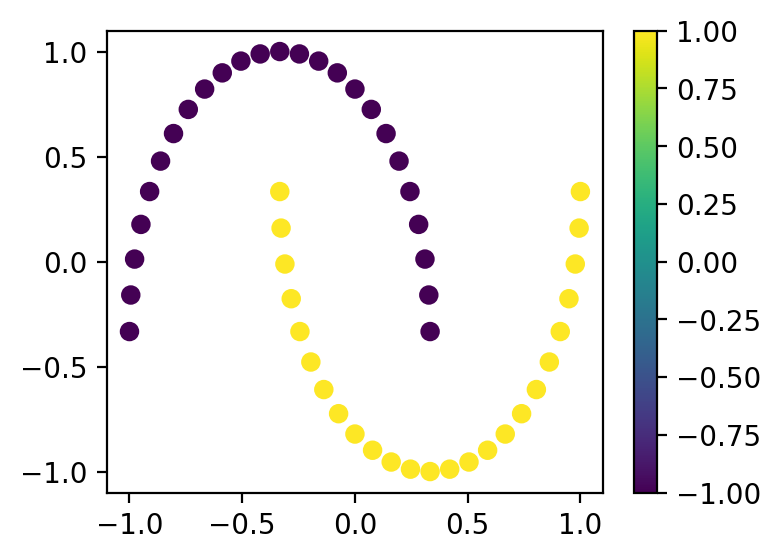

In [4]:
x_samples, y_samples = make_moons(n_samples=50)
y_samples = y_samples * 2 - 1

x_samples[:, 0] = normalize(x_samples[:, 0])
x_samples[:, 1] = normalize(x_samples[:, 1])

plt.figure(figsize=(4, 3))
cb = plt.scatter(x_samples[:, 0], x_samples[:, 1], c=y_samples)
plt.colorbar(cb)
plt.show()

И привычное нам объявление устройства.

In [5]:
dev = qml.device("default.qubit", 2)

Теперь давайте для начала реализуем наше преобразование над одним из векторов ($U(x)$).

In [6]:
def var_layer(x):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)

    qml.U1(x[0], wires=0)
    qml.U1(x[1], wires=1)

    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)

    qml.CNOT(wires=[0, 1])
    qml.U1(np.pi * np.cos(x[0]) * np.cos(x[1]), wires=1)
    qml.CNOT(wires=[0, 1])

А теперь реализуем

$$
\braket{U(x_1)|U(x_2)} = \bra{U(x_1)U(x_2)^\dagger \Psi} M_0 \ket{U(x_1)U(x_2)^\dagger \Psi},
$$

где $M_0$ -- проектор на один из собственных векторов системы кубитов, а именно на "нулевой":

$$
M_0 = \ket{0, ..., 0}\bra{0, ..., 0}.
$$

Проще говоря, мы реализуем схему, которая нам дает вероятности каждой из битовых строк (а дальше мы просто возьмем первую, она и отвечает строке $0,...0$):

In [7]:
@qml.qnode(dev)
def dot_prod(x1, x2):
    var_layer(x1)
    qml.adjoint(var_layer)(x2)

    return qml.probs(wires=[0, 1])

Ну и сразу вспомогательную функцию, которая нам считает то, что нам было нужно:

In [8]:
def q_dot_prod(x, i, j):
    x1 = (x[i, 0], x[i, 1])
    x2 = (x[j, 0], x[j, 1])

    return dot_prod(x1, x2)[0]

Для самопроверки убедимся в том, что наше "скалярное произведение" симметрично:

In [9]:
print(np.allclose(q_dot_prod(x_samples, 0, 1), q_dot_prod(x_samples, 1, 0)))

True


И сразу посмотрим на то, как выглядит наша схема:

In [10]:
print(qml.draw(dot_prod)(x_samples, y_samples))

 0: ──H──U1(M0)──H──╭C──────────╭C──╭C──────────────╭C──H──U1(-1)──H──╭┤ Probs 
 1: ──H──U1(M1)──H──╰X──U1(M2)──╰X──╰X──U1(-0.917)──╰X──H──U1(-1)──H──╰┤ Probs 
M0 =
[ 0.33333333 -1.        ]
M1 =
[ 0.07821105 -0.89850604]
M2 =
[2.9595948  1.05711205]



### Гибридный SVM

Мы не будем сами с нуля писать решение задачи квадратичного программирования, просто воспользуемся готовой рутиной из `scikit-learn`. Используемая там реализация позволяет вместо ядерной функции передать сразу матрицу Грама ([Gram matrix](https://en.wikipedia.org/wiki/Gram_matrix)). На самом деле это просто матрица всех попарных скалярных произведений наших векторов. Вычислим ее, сразу воспользовавшись тем, что

$$
\braket{U(x)|U(x)} = 1 \quad \text{и} \quad \braket{U(x_1)|U(x_2)} = \braket{U(x_2)|U(x_1)}
$$

In [11]:
gram_mat = np.zeros((x_samples.shape[0], x_samples.shape[0]))

for i in range(x_samples.shape[0]):
    for j in range(x_samples.shape[0]):
        if i == j:
            gram_mat[i, j] = 1
        if i > j:
            r = q_dot_prod(x_samples, i, j)
            gram_mat[i, j] = r
            gram_mat[j, i] = r

Обучим нашу модель:

In [12]:
model = SVC(kernel="precomputed")
model.fit(gram_mat, y_samples)

SVC(kernel='precomputed')

Посчитаем предсказания и посмотрим на результат:

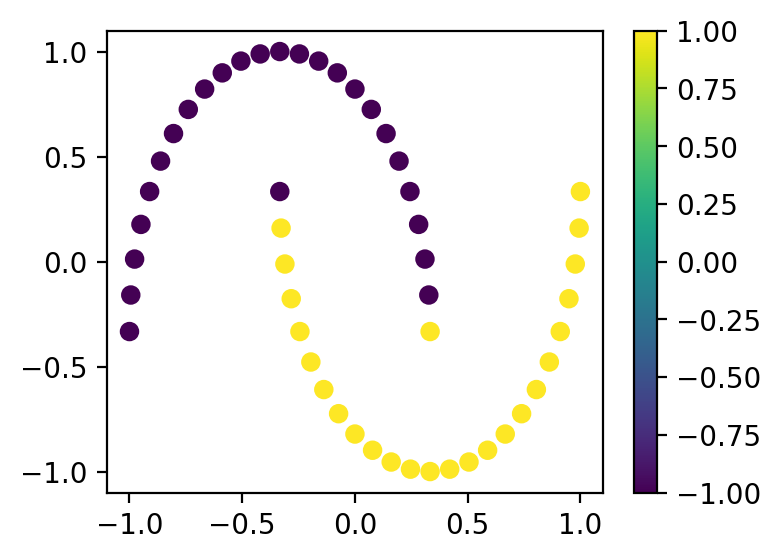

In [13]:
preds = model.predict(X=gram_mat)

plt.figure(figsize=(4, 3))
cb = plt.scatter(x_samples[:, 0], x_samples[:, 1], c=preds)
plt.colorbar(cb)
plt.show()

Результат выглядит неплохо!

## Заключение

Расчет полной матрицы скалярных произведений дает нам сложность $O(N^2)$ вызовов. Но основной потенциал гибридного SVM в том, что задачу квадратичной оптимизации на самом деле можно тоже решать на квантовом компьютере, используя алгоритм Гровера (про него рассказано в ранних лекциях), причем за сложность всего $O(N)$ и без расчета полной матрицы Грама!

Многие считают, что NISQ квантовые компьютеры могут стать для SVM чем-то типа видеокарт для нейронных сетей и вернуть этот алгоритм на пьедестал лучших алгоритмов машинного обучения!